In [1]:
import numpy as np
import scipy as sc
import scipy.integrate
import matplotlib.pyplot as plt
import warnings
import tqdm as tqdm
import scripts.liblie as ll
import scripts.GPs as GPs
%matplotlib notebook

In [15]:
def T_q(phi, t):
    T = np.eye(4,4)
    
    T[:3,:3] = ll.expm_so3(ll.wedge_so3(phi))
    T[:3,3] = t
    
    return T
    
def dist(p,q):
    return np.linalg.norm(p-q)

def plot_theodolite(ax, T, c1='tab:red', c2='tab:green', name=""):
    b = T@np.array([0,0,0,1])
    dx = T@np.array([1,0,0,1]) - b
    dy = T@np.array([0,1,0,1]) - b
    
    plt.arrow(*b[:2], *dx[:2], color=c1)
    plt.arrow(*b[:2], *dy[:2], color=c2)
    plt.text(*b[:2],name)
    
def traj(t):
    x = t
    y = t+np.cos(t) - 10*np.exp(.1*(t-10))
    z=0
    theta = np.arctan2(1-np.sin(t)-np.exp(.1*(t-10)), 1)
    
    phi = np.array([0,0,theta])
    
    return phi, x, y, z

def g(xi):
    ys = np.zeros(len(ts)*3)
    
    for i in range(len(ts)):
            T = T_q(xi[12*i:12*i+3], xi[12*i+3:12*i+6])
            ys[3*i:3*(i+1)] = (T@prisms_sorted[i])[:3]
            #ys[3*i:3*(i+1)] = (T@prisms[i%3])[:3]
    return ys
            
# print(g(np.array([0]*4*3*len(ts))))

def jacobian(f, x, eps=1e-5):
    f_op = f(x)
    J = np.zeros((f_op.shape[0], x.shape[0]))
    
    for j in range(x.shape[0]):
        x_p = np.array(x)
        x_p[j] += eps
        
        J[:,j] = (f(x_p) - f_op) / eps
    return J

def G(xi):
    #approximate derivative
    Bk = []
    for i in range(len(ts)): #=xi.shape[0]/6
        #f = lambda xi: (T_q(xi[:3], xi[3:6])@prisms[i%3])[:3]
        f = lambda xi: (T_q(xi[:3], xi[3:6])@prisms_sorted[i])[:3]
        Bk += [jacobian(f, xi[12*i: 12*(i+1)])]
    
    return sc.linalg.block_diag(*Bk)

def int_exp(dt):
    return dt*np.eye(*A.shape) + dt**2/2.*A

def gen_points(N):
    p1s = np.zeros((4,N))
    p2s = np.zeros((4,N))
    p3s = np.zeros((4,N))
    
    ts = []
    
    poses = []
    for i in range(N):
        ti = float(i)/freq_th
        for j in range(3):
            t = ti + t_shift[j] + (.001*(np.random.rand()-.5)) #small noise so random intervals
            phi, x, y, z = traj(t)
            T = T_q(phi, np.array([x,y,z]))
            if j==0:
                p1s[:,i] = T@prisms[0]
            elif j==1:
                p2s[:,i] = T@prisms[1]
            elif j==2:
                p3s[:,i] = T@prisms[2]
                
            poses += [*phi, x, y, z]
            ts += [t]
    
    ts = np.array(ts)    
    poses=np.array(poses)
    
    return ts, poses, p1s, p2s, p3s

In [ ]:
d_truth = 1
#def traj circle
prisms = np.array([[0,0,0,1], [0,d_truth,0,1], T_q(np.array([0,0,np.pi/3.]), np.array([0,0,0]))@np.array([0,d_truth,0,1])])
center = np.mean(prisms, 0)
center[3]=0

for i in range(len(prisms)):
    prisms[i] -= center
    
prisms[1][2] = .5
prisms[2][2] = 1

#def traj circle
freq_th = 2#Hz
t_shift = [0,.1,.4]

N=15
ts, poses, p1s, p2s, p3s = gen_points(N)

plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()

plot_theodolite(ax,np.eye(4,4), name="T1")

plt.scatter(p1s[0,:], p1s[1,:], color='tab:red')
plt.scatter(p2s[0,:], p2s[1,:], color='tab:red')
plt.scatter(p3s[0,:], p3s[1,:], color='tab:blue')

xs=[]
ys=[]
for i in range(len(ts)):
    xs += [poses[i*6+3]]
    ys += [poses[i*6+4]]
    plt.text(xs[-1], ys[-1], "{:.2f}".format(ts[i]))

plt.scatter(xs, ys, marker='x', s=100, color='tab:green')

In [ ]:
# ---------------------------------------------------------------------------
# def measurements function
# ---------------------------------------------------------------------------



measurements = np.zeros(len(ts)*3) #points in 3D
for i in range(p1s.shape[1]):
    measurements[i*9 + 0 : i*9 + 3] = p1s[:3, i] + .002*np.random.normal(size=3)
    measurements[i*9 + 3 : i*9 + 6] = p2s[:3, i] + .002*np.random.normal(size=3)
    measurements[i*9 + 6 : i*9 + 9] = p3s[:3, i] + .002*np.random.normal(size=3)
    
# Rk = np.eye(3,3)*0.005**2
# R = sc.linalg.block_diag(*[Rk]*len(ts))
R = np.eye(len(ts)*3, len(ts)*3)*0.002**2

In [ ]:
# # #---------------------------------------------------------------------------
# # #def system
# # #---------------------------------------------------------------------------

A = np.block([[np.zeros((6,6)), np.eye(6,6)],
              [np.zeros((6,6)), np.zeros((6,6))]])
    
us =  np.zeros(len(ts)-1)
#if B = 0, the system does not take into account the command
B = np.zeros((12,1))
# B[2,0] = B[3,1] = 1 #command acceleration
#----------------------------------------------------------

L = np.block([[np.zeros((6,6))],
              [np.eye(6,6)]]) #noise on acceleration
Q = np.eye(6,6)* 1**2
Q[0,0] = Q[1,1] = np.radians(20)**2 #roll and pitch
Q[2,2] = np.radians(20)**2 #yaw
Q[5,5] = .2**2 # z acceleration is lower

#initial position/speed and cov
x0 = np.array([0.]*12)
P0 = np.eye(12,12) * 1000**2

#create noisy guess
x_sol = np.zeros(12*len(ts))

# prior
for i in range(len(ts)):
    x_sol[12*i : 12*i+6] = poses[6*i : 6*i+6] + .5*np.random.normal(size=6)
    
sys_2DWarthog = GPs.LTI_system(A,B,L,Q, int_exp=int_exp)
gp = GPs.GPs_LTI_nL_m(sys_2DWarthog, ts, us, measurements, g, G, R, P0=P0, x0=x0, max_it=10, initial_guess=x_sol, rtol=1e-8)
# GPs = GPs_LTI(sys_2DWarthog, ts, us, measurements, C, R, P0=P0, x0=x0)
post_mean = gp.infer_mean()
post_covs = gp.infer_covariance()
post_mean_r = post_mean.reshape(-1, 12)

xs = post_mean_r[:,3]
ys = post_mean_r[:,4]
plt.scatter(xs, ys, c='tab:purple', marker='o', s=100, label='posterior mean', alpha=.3)

taus = np.linspace(min(ts)+1e-2,max(ts),100, endpoint=False)
xs = []
ys = []
zs = []
phi1 = []
phi2 = []
phi3 = []
covs = []
print("Querying trajectory...")
for tau in tqdm.tqdm(taus):
    m, cov = gp.query_posterior(tau)
    xs += [m[3]]
    ys += [m[4]]
    zs += [m[5]]
    phi1 += [m[0]]
    phi2 += [m[1]]
    phi3 += [m[2]]
    covs += [cov]
    GPs.plot_ellipse(plt.gca(), [xs[-1], ys[-1]], (cov[3:5, 3:5]), color='tab:gray', alpha=.3, zorder=0)

plt.plot(xs, ys, c='tab:gray', ls='--', label='posterior mean interpolated')    

In [ ]:


err_m_t = []
err_a_t = []
err_m_r = []
err_a_r = []
for tau,i,cov in zip(taus, range(len(taus)), covs):
    tr= traj(tau)
    gt = np.array([*tr[0], *tr[1:]])
    e_r = np.array(gt[:3] - np.array([phi1[i], phi2[i], phi3[i]]))[np.newaxis].T
    e_t = np.array(gt[3:] - np.array([xs[i], ys[i], zs[i]]))[np.newaxis].T
#     
    err_m_r += [np.sqrt((e_r.T@np.linalg.inv(cov[:3,:3])@e_r)[0,0])]
    err_a_r += [np.sqrt((e_r.T@e_r)[0,0])]
    err_m_t += [np.sqrt((e_t.T@np.linalg.inv(cov[3:6,3:6])@e_t)[0,0])]
    err_a_t += [np.sqrt((e_t.T@e_t)[0,0])]

fig,axs_r = plt.subplots(2,2, figsize=(10,5))
plt.suptitle("Rotation")
axs_r[0,0].boxplot(err_m_r, showfliers=False)
axs_r[0,0].set_title("Mahalanobis []")
axs_r[0,1].boxplot(np.degrees(err_a_r), showfliers=False)
axs_r[0,1].set_title("Absolute [deg]")

fig,axs_t = plt.subplots(2,2, figsize=(10,5))
plt.suptitle("Translation")
axs_t[0,0].boxplot(err_m_t, showfliers=False)
axs_t[0,0].set_title("Mahalanobis []")
axs_t[0,1].boxplot(err_a_t, showfliers=False)
axs_t[0,1].set_title("Absolute [m]")


err_m_t = []
err_a_t = []
err_m_r = []
err_a_r = []
for t, i in zip(ts, range(len(ts))):
    tr= traj(t)
    gt = np.array([*tr[0], *tr[1:]])
    m = post_mean_r[i][:6]
    cov = post_covs[12*i:12*(i+1), 12*i:12*(i+1)]
    
    e_r = np.array(gt[:3] - m[:3])[np.newaxis].T
    e_t = np.array(gt[3:] - m[3:])[np.newaxis].T
#     
    err_m_r += [np.sqrt((e_r.T@np.linalg.inv(cov[3:6,3:6])@e_r)[0,0])]
    err_a_r += [np.sqrt((e_r.T@e_r)[0,0])]
    err_m_t += [np.sqrt((e_t.T@np.linalg.inv(cov[3:6,3:6])@e_t)[0,0])]
    err_a_t += [np.sqrt((e_t.T@e_t)[0,0])]

axs_r[1,0].boxplot(err_m_r, showfliers=False)
axs_r[1,0].set_title("Mahalanobis []")
axs_r[1,1].boxplot(err_a_r, showfliers=False)
axs_r[1,1].set_title("Absolute [deg]")

axs_t[1,0].boxplot(err_m_t, showfliers=False)
axs_t[1,0].set_title("Mahalanobis []")
axs_t[1,1].boxplot(err_a_t, showfliers=False)
axs_t[1,1].set_title("Absolute [m]")
# plt.figure()
# # plt.plot(post_mean_r[:,3],post_mean_r[:,4]) 
# # plt.plot([traj(t)[1] for t in ts], [traj(t)[2] for t in ts]) 

# plt.boxplot([ts[i+1]-ts[i] for i in range(len(ts)-1)], showfliers=False)

In [16]:
import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as ttf
import GPy
import scripts.gp_prediction_utils as GPf
import scripts.GPs as GPs
import scripts.liblie as LB
tfu = importlib.reload(tfu)
ttf = importlib.reload(ttf)
GPf = importlib.reload(GPf)
GPs = importlib.reload(GPs)
LB = importlib.reload(LB)


# Read rosbag of grand axe and show the trajectory
ttf = importlib.reload(ttf)
tfu = importlib.reload(tfu)
GPf = importlib.reload(GPf)

file = "/home/norlab/Data/IROS_2022/20220505_TS/cones1_2022-05-05-19-25-54.bag"
file_tf = './data/calibration/tf_automated_resection/20220505_cones_tf.csv'

output = "TS/20220505_cones/"


# General parameters 
filtering = True
thresold_d = 2                 # m/s
thresold_a = 1                 # deg/s
thresold_e = 1                 # deg/s
limit_time_interval = 1        # s
path_output = "./data/prediction/"
Mode = "L"
limit_search = limit_time_interval
size_interval = 6           # Minimum time size sub-interval 
delta_t = 0               # Value to remove points near edge of time intervals
save = True

if(not filtering):
    path = output + "raw/"
else:
    path = output + "filtered/"

if(filtering):
    t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = ttf.read_rosbag_theodolite_without_tf_raw_data_pre_filtered(file)
    index_1_f = ttf.thresold_raw_data(t1, d1, a1, e1, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
    index_2_f = ttf.thresold_raw_data(t2, d2, a2, e2, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
    index_3_f = ttf.thresold_raw_data(t3, d3, a3, e3, thresold_d, thresold_a*3.1415926/180, thresold_e*3.1415926/180, limit_time_interval)
    t1 = t1[index_1_f]
    t2 = t2[index_2_f]
    t3 = t3[index_3_f]
    tp1 = tp1[index_1_f].T
    tp2 = tp2[index_2_f].T
    tp3 = tp3[index_3_f].T
    print(len(t1),len(t2),len(t3))
else:
    t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = ttf.read_rosbag_theodolite_without_tf_raw_data(fname)
    print(len(t1),len(t2),len(t3))

list_interval, list_time = tfu.split_time_interval_all_data(t1, t2, t3, limit_time_interval)
list_trajectories_split = tfu.merge_interval(list_interval, list_time, t1, t2, t3, limit_search)

# premier interval
i = list_trajectories_split[1]
index_1 = np.array([i[0,0],i[1,0]])
index_2 = np.array([i[0,1],i[1,1]])
index_3 = np.array([i[0,2],i[1,2]])

begin = np.max([t1[index_1[0]], t2[index_2[0]], t3[index_3[0]]])+delta_t
end = np.min([t1[index_1[1]], t2[index_2[1]], t3[index_3[1]]])-delta_t

Prediction_1 = []
Prediction_2 = []
Prediction_3 = []
T_prediction = []
T_prediction_sorted = []
corrected_points = []
measurements_sorted = []
prisms = []
prisms_sorted = []

P_groundtruth = np.array([[-0.3926683261421169, -0.06981451458695287, 0.37458416859960275,  1.],
        [-0.6480596685770119, -0.11178020130204336, 0.0936504044016776,  1.],
        [-0.6413256219354304, 0.14408137810898047, 0.07735247913826593,  1.]])

Tf = ttf.read_saved_tf(file_tf)

if(abs(end-begin)>size_interval and begin<end):
    
    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = GPf.data_training_L(t1, t2, t3, tp1, tp2, tp3, index_1, index_2, index_3)
    print("Prediction")
    mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3 = GPf.linear_interpolation(T1, X1, Y1, Z1, T2, X2, Y2, Z2,T3, X3, Y3, Z3)
    
    for time_1 in T1:
        if(time_1>begin and time_1<end):
            T_prediction.append(time_1)
            prisms.append(P_groundtruth[0])
    for time_2 in T2:
        if(time_2>begin and time_2<end):
            T_prediction.append(time_2)
            prisms.append(P_groundtruth[1])
    for time_3 in T3:
        if(time_3>begin and time_3<end):
            T_prediction.append(time_3)
            prisms.append(P_groundtruth[2])
    
    for i_x, i_y, i_z in zip(X1, Y1, Z1):
        points = np.array([i_x,i_y,i_z,1])
        corrected_points.append(Tf[0]@points)
    for i_x, i_y, i_z in zip(X2, Y2, Z2):
        points = np.array([i_x,i_y,i_z,1])
        corrected_points.append(Tf[1]@points)
    for i_x, i_y, i_z in zip(X3, Y3, Z3):
        points = np.array([i_x,i_y,i_z,1])
        corrected_points.append(Tf[2]@points)
        
    sorted_index_time = [index for index, num in sorted(enumerate(T_prediction), key=lambda x: x[-1])]
    for index_time in sorted_index_time:
        T_prediction_sorted.append(T_prediction[index_time])
        measurements_sorted.append(corrected_points[index_time][0])
        measurements_sorted.append(corrected_points[index_time][1])
        measurements_sorted.append(corrected_points[index_time][2])
        prisms_sorted.append(prisms[index_time])

    time_origin = 0
    for i_time in T_prediction_sorted:
        P1_GP, P2_GP, P3_GP = GPf.linear_prediction_2(i_time, time_origin, mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3)
        
        Prediction_1.append(Tf[0]@P1_GP)
        Prediction_2.append(Tf[1]@P2_GP)
        Prediction_3.append(Tf[2]@P3_GP)
        

Number of data for theodolites: [614 653 638]
Bad measures: 67
573 630 610
Prediction


In [17]:
P1 = np.array(Prediction_1)
P2 = np.array(Prediction_2)
P3 = np.array(Prediction_3)

Pose_lidar = []
Prism_corrected = []
number = len(P1)
for i in range(0,number):
    Q = np.array([P1[i,0:4], P2[i,0:4], P3[i,0:4]]).T
    T = ttf.point_to_point_minimization(P_groundtruth.T, Q)
    Pose_lidar.append(T)
    prism_correct = T@P_groundtruth.T
    Prism_corrected.append(prism_correct)

In [18]:
LB = importlib.reload(LB)

def f_speed(before, after, timestamp_diff):
    return (after-before)/timestamp_diff

prior = []
pose_before = np.array([0,0,0,0,0,0])
timestamp_before = 0
for i,j in zip(Pose_lidar,T_prediction_sorted):
    t = np.array(i[:,3])
    phi = LB.vee_so3(i[0:3,0:3])
    if(timestamp_before==0):
        timestamp_before = j
        pose_before = np.array([t[0],t[1],t[2],phi[0],phi[1],phi[2]])
    else:
        speed = np.array([f_speed(pose_before[0],t[0],j-timestamp_before),
                         f_speed(pose_before[1],t[1],j-timestamp_before),
                         f_speed(pose_before[2],t[2],j-timestamp_before),
                         f_speed(pose_before[3],phi[0],j-timestamp_before),
                         f_speed(pose_before[4],phi[0],j-timestamp_before),
                         f_speed(pose_before[5],phi[0],j-timestamp_before)])
        prior.append(t[0])
        prior.append(t[1])
        prior.append(t[2])
        prior.append(phi[0])
        prior.append(phi[1])
        prior.append(phi[2])
        prior.append(speed[0])
        prior.append(speed[1])
        prior.append(speed[2])
        prior.append(speed[3])
        prior.append(speed[4])
        prior.append(speed[5])

prior = np.array(prior)

In [19]:
measurements_sorted.pop(0)
measurements_sorted.pop(0)
measurements_sorted.pop(0)
T_prediction_sorted.pop(0)
prisms_sorted.pop(0)

array([-0.64805967, -0.1117802 ,  0.0936504 ,  1.        ])

In [20]:
print(len(prior)/12)
print(len(measurements_sorted)/3)
print(len(T_prediction_sorted))

166.0
166.0
166


Iteration [9]: 61.9742 % gain |=========================| : 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


<IPython.core.display.Javascript object>


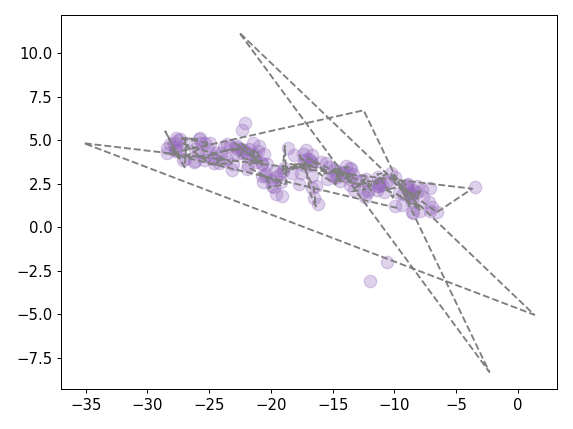

Querying trajectory...


100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


In [21]:
# Remap of variable
ts = np.array(T_prediction_sorted)
x_sol = np.array(prior)
measurements = np.array(measurements_sorted)

# # #---------------------------------------------------------------------------
# # #def system
# # #---------------------------------------------------------------------------

A = np.block([[np.zeros((6,6)), np.eye(6,6)],
              [np.zeros((6,6)), np.zeros((6,6))]])
    
us =  np.zeros(len(ts)-1)
#if B = 0, the system does not take into account the command
B = np.zeros((12,1))
# B[2,0] = B[3,1] = 1 #command acceleration
R = np.eye(len(ts)*3, len(ts)*3)*0.002**2
#----------------------------------------------------------

L = np.block([[np.zeros((6,6))],
              [np.eye(6,6)]]) #noise on acceleration
Q = np.eye(6,6)* 1**2
Q[0,0] = Q[1,1] = np.radians(20)**2 #roll and pitch
Q[2,2] = np.radians(20)**2 #yaw
Q[5,5] = .2**2 # z acceleration is lower

#initial position/speed and cov
x0 = np.array([0.]*12)
P0 = np.eye(12,12) * 1000**2

#create noisy guess
#x_sol = np.zeros(12*len(ts))

# prior
#for i in range(len(ts)):
#    x_sol[12*i : 12*i+6] = poses[6*i : 6*i+6] + .5*np.random.normal(size=6)
    
sys_2DWarthog = GPs.LTI_system(A,B,L,Q, int_exp=int_exp)
gp = GPs.GPs_LTI_nL_m(sys_2DWarthog, ts, us, measurements, g, G, R, P0=P0, x0=x0, max_it=10, initial_guess=x_sol, rtol=1e-8)
# GPs = GPs_LTI(sys_2DWarthog, ts, us, measurements, C, R, P0=P0, x0=x0)


post_mean = gp.infer_mean()
post_covs = gp.infer_covariance()
post_mean_r = post_mean.reshape(-1, 12)

xs = post_mean_r[:,3]
ys = post_mean_r[:,4]
plt.scatter(xs, ys, c='tab:purple', marker='o', s=100, label='posterior mean', alpha=.3)

taus = np.linspace(min(ts)+1e-2,max(ts),100, endpoint=False)
xs = []
ys = []
zs = []
phi1 = []
phi2 = []
phi3 = []
covs = []
print("Querying trajectory...")
for tau in tqdm.tqdm(taus):
    m, cov = gp.query_posterior(tau)
    xs += [m[3]]
    ys += [m[4]]
    zs += [m[5]]
    phi1 += [m[0]]
    phi2 += [m[1]]
    phi3 += [m[2]]
    covs += [cov]
    GPs.plot_ellipse(plt.gca(), [xs[-1], ys[-1]], (cov[3:5, 3:5]), color='tab:gray', alpha=.3, zorder=0)

plt.plot(xs, ys, c='tab:gray', ls='--', label='posterior mean interpolated')    

In [22]:
#plt.savefig("./figs/test_SE3_GP.jpg")